 # 沪深300指数纯因子组合构建

 > WIFA量化组，2019年春。

 依据多因子模型，尝试对沪深300指数构建纯因子组合。

 注：由于数据都已经保存在本地，
 > 故代码中提取及保存数据的部分都暂时被注释了。

In [1]:
from scipy.optimize import minimize
# from WindPy import *
# import WindPy as w                           # for data fetching.
import statsmodels.api as sm                 # for OLS result.
from statsmodels import regression           # for OLS.
import math                                  # math calculation.
import matplotlib.pyplot as plt              # specify "plt".
import seaborn as sns                        # for plotting.
import numpy as np                           # for numerical manipulation.
import pandas as pd                          # for wrapping csv file.
import os                                    # for getting working directory.
path = os.getcwd()                           # current working directory.
sns.set(style="darkgrid")                    # set seaborn style.
plt.rcParams['font.sans-serif'] = ['SimHei']  # For displaying chinese.
plt.rcParams['axes.unicode_minus'] = False   # For displaying minus sign.


In [2]:
# # Import Wind Module for getting data.
# w.start()


 # Step 1：因子数据库构建

 因子数据分为**风格因子**和**风险因子**。

 其中风格因子又分为大类因子和细分类因子，最终风格因子会由细分类因子合成。

 风格因子共选取以下7个大类中的19个因子：

 - VALUE：EPS_TTM/P、BPS_LR/P、CFPS_TTM/P、SP_TTM/P
 - GROWTH：NetProfit_SQ_YOY、Sales_SQ_YOY、ROE_SQ_YOY
 - PROFIT：ROE_TTM、ROA_TTM
 - QUALITY：Debt2Asset、AssetTurnover、InvTurnover
 - MOMENTUM：Ret1M、Ret3M、Ret6M
 - VOLATILITY：RealizedVol_3M、RealizedVol_6M
 - LIQUIDITY：Turnover_ave_1M、Turnover_ave_3M

 风险因子选取以下2个大类中的2个因子：

 - INDUSTRY：中信一级行业
 - SIZE：Ln_MarketValue

In [2]:


def get_factors_list():
    '''
    Return factor list. (str list)

    保存所需因子（万德）指标名。

        保存的字段名即万德金融API(此处使用WindPy)的指标字段名。

    其中"pct_chg_1m",
        "pct_chg_3m",
        "pct_chg_6m",
        "stdevry_3m",
        "stdevry_6m",
        不好从wsd中取。

    所以"pct_chg_1m", 
        "pct_chg_3m",   
        "pct_chg_6m"
        是根据pct_chg计算的。

    波动率提取要填开始区间和截止区间。（区间为近几个月）
    '''
    return [
        "pe_ttm", "pb_lf", "pcf_ncf_ttm", "ps_ttm",
        "yoyprofit", "yoy_or", "yoyroe", "roe_ttm2",
        "roa_ttm2", "debttoassets", "assetsturn", "invturn",
        "pct_chg_1m", "pct_chg_3m", "pct_chg_6m", "stdevry_3m",
        "stdevry_6m", "tech_turnoverrate20", "tech_turnoverrate60", "val_lnmv"
    ]


In [3]:


def get_large_factors_list():
    '''
    Return large factors list. (str list)

    保存大类因子指标名。
    '''
    return [
        'VALUE', 'GROWTH', 'PROFIT',
        'QUALITY', 'MOMENTUM', 'VOLATILITY',
        'LIQUIDITY', 'INDUSTRY', 'SIZE'
    ]


 由于数据限制和平台选择，最终确定的因子和最初选取的因子比较如下：

 最初选取因子|最终确定因子|因子解释
 :--:|:--:|:--:
 EPS_TTM/P|PE_TTM|市盈率
 BPS_LR/P|PB_LF|指定日最新公告股东权益
 CFPS_TTM/P|PCF_NCF_TTM|市现率（现金净流量）
 SP_TTM/P|PS_TTM|市销率
 NetProfit_SQ_YOY|YOYPROFIT|净利润同比增长率
 Sales_SQ_YOY|YOY_OR|营业收入同比增长率
 ROE_SQ_YOY|YOYROE|净资产收益率同比增长率
 ROE_TTM|ROE_TTM2|净资产收益率
 ROA_TTM|ROA_TTM2|总资产净利率
 Debt2Asset|DEBTTOASSETS|资产负债率
 AssetTurnover|ASSETSTURN|总资产周转率
 InvTurnover|INVTURN|存货周转率
 Ret1M|PCT_CHG|涨跌幅
 Ret3M|PCT_CHG|涨跌幅
 Ret6M|PCT_CHG|涨跌幅
 RealizedVol_3M|STDEVRY|3月年化波动率
 RealizedVol_6M|STDEVRY|6月年化波动率
 Turnover_ave_1M|TECH_TURNOVERRATE20|20日平均换手率
 Turnover_ave_3M|TECH_TURNOVERRATE60|60日平均换手率
 中信一级行业列表|INDUSTRY_SW|申万行业名称
 Ln_MarketValue|VAL_LNMV|对数市值

In [4]:


def get_hs300_stocks_list():
    '''
    Return hs300 stocks list. (pd.DataFrame)
    '''

    file_path = path + "\\H3 Data\\Raw Data\\hs300.csv"

    # If file already exist, load from disk.
    if os.path.isfile(file_path):
        hs300_data = pd.read_csv(open(
            file_path,
            'r',
            encoding="utf-8"
        ), index_col=[0])

    # If file doesn't exist yet, fetch from WindPy.
    # else:
    #     # Getting the stock list of HS300.
    #     hs300_stocks_list = list(w.wset(
    #         "sectorconstituent",
    #         "date=2019-02-20;windcode=000300.SH",  # base on recent date.
    #         usedf=True
    #     )[1]['wind_code'])

    #     hs300_data = pd.DataFrame(
    #         data=hs300_stocks_list,
    #         columns=["HS300"]
    #     )
    #     # Store to disk.
    #     hs300_data.to_csv(file_path)

    return list(hs300_data["HS300"])


In [5]:


def factor_data_fetching_and_storing(
    start="2005-01-01",
    end="2019-02-20"
):
    '''
    Parameters:
        start: start date (YYYY-MM-DD). (str)
        end: end date (YYYY-MM-DD). (str)
    Return:
        save raw data to "\\H3 Data\\Raw Data\\" as csv.
    '''
    # # Import data from wind and store it as csv.
    # for factor in get_factors_list():
    #     # Get each factor data from Wind.
    #     factor_data = w.wsd(
    #         get_hs300_stocks_list(),
    #         factor,
    #         start,
    #         end,
    #         "Period=M",
    #         usedf=True  # use pandas dataframe.
    #     )[1]            # the result is a tuple and we only need [1].
    #     # Name the data file by it's factor string.
    #     file_path = path + "\\H3 Data\\Raw Data\\" + factor + ".csv"
    #     factor_data.to_csv(file_path)  # store data.



In [6]:
# factor_data_fetching_and_storing()


In [7]:


def sw_industry_data_fetching_and_storing():
    '''
    Return: save SHENWAN industry data to "\\H3 Data\\Raw Data\\" as csv.
    '''
    # industry_sw = w.wsd(
    #     get_hs300_stocks_list(),
    #     "industry_sw",
    #     "2019-02-20",
    #     "2019-02-20",  # set the start and end date as the same.
    #     "industryType=1;Period=M",
    #     usedf=True
    # )[1]
    # file_path = path + "\\H3 Data\\Raw Data\\industry_sw.csv"
    # industry_sw.to_csv(file_path)


In [8]:
# sw_industry_data_fetching_and_storing()



 > （注：Ret1M, Ret3M, Ret6M皆由PCT_CHG合成；RealizedVol_3M, RealizedVol_6M皆由UNDERLYINGHISVOL_90D代替。）
 >
 > 数据来源为万德金融数据库，通过WindPy API获取。
 >
 > 其中“最终确定因子”列即为其万德指标字段名。
 >
 > （数据保存在“H3 Data” ("HS300 Data" 的缩写) 文件夹中，格式为CSV，直接用全小写的万德指标名命名。
 > 即 "<万德指标名>.csv"，如 "pe_ttm.csv"）
 >
 > 获取的原始数据储存在"H3 Data/Raw Data"文件夹里。

 数据格式如下：

 行/列 | 股票代号（000001.SZ）
 :--|--:
 交易日期（YYYYMMDD） | 相应因子暴露

 # Step 2：因子数据处理

 > 对因子数据进行处理。

In [9]:


def get_data(
    factor_name, 
    category="Raw", 
    start_year="2009"
):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
        category: which category of data. (str)
            - "Raw"
            - "Processed"
            - "Neutralized"
            - "Large Factor Dynamic"
            - "Large Factor Static"
        start_year: the year when data start. (str) 
    Return:
        forward-filled factor data. (pd.DataFrame)
            index: months. (np.int64)
            columns: stocks code list. (str)
    '''
    data = pd.read_csv(open(
        # Extract raw data.
        path + "\\H3 Data\\" + category + " Data\\" + factor_name + ".csv",
        # read-only mode for data protection.
        'r',
        encoding="utf-8"
    ), index_col=[0])

    # Forward-fill nan to make quarter report fill the month.
    data.fillna(method='ffill', inplace=True)

    if factor_name == "industry_sw":
        pass

    else:
        # Composite-data's date is formated already.
        # There'll be a wired bug if you insist to format again. 
        # All of the date would be "1990-01-01". 
        if (category=="Raw") & (
            factor_name not in [
                "pct_chg_1m", 
                "pct_chg_3m", 
                "pct_chg_6m"
            ]
        ):
            # Make all date format in the same way.
            data.index = pd.to_datetime(data.index).strftime('%Y%m%d')
        data = data.loc[start_year+'0131' : '20190131']
    return data


In [10]:


def pct_chg_composition():
    '''
    Return: composite and store pct_chg_3m, pct_chg_6m factor data.
    '''
    # Turn percentage format from percent to decimal.
    pct_chg_data = get_data("pct_chg")/100 + 1

    pct_chg_1m = pct_chg_data - 1
    pct_chg_3m = pct_chg_data.rolling(3).apply(lambda x: np.prod(x)) - 1
    pct_chg_6m = pct_chg_data.rolling(6).apply(lambda x: np.prod(x)) - 1

    for factor_data, factor_name in zip(
        [pct_chg_1m, pct_chg_3m, pct_chg_6m],
        ["pct_chg_1m", "pct_chg_3m", "pct_chg_6m"]
    ):
        factor_data.index = pd.to_datetime(
            factor_data.index
        ).strftime('%Y%m%d')

        factor_data.to_csv(
            path
            + "\\H3 Data\\Raw Data\\"
            + factor_name
            + ".csv"
        )


In [11]:
# pct_chg_composition()


In [12]:


def get_values(data):
    '''
    Parameter:
        data: input data. (pd.DataFrame)
    Return:
        a list of all values in data except nan. (list)
    '''
    # Collect all non-nan value into data_list.
    value_list = []
    for i in range(len(data.columns)):
        # is there a way to avoid loop?
        value_list += data.iloc[:, i].dropna().tolist()
    return value_list


In [13]:


def overview(
    source_data_function,
    title
):
    '''
    Parameters:
        source_data_function: 
            the function to get source data for plot. (function)
        title: 
            the title of the plot as well as the file. (str)
    Return: save a 3*3 histogram distribution plot of data.
    '''
    factors_list = get_factors_list()[:9]

    plt.figure(figsize=(10, 10))
    for i, factor in zip(
        range(len(factors_list)),
        factors_list
    ):
        plt.subplot(int("33" + str(i+1)))
        sns.distplot(get_values(
            data=source_data_function(factor)
        ))
        plt.title(factor)

    plt.suptitle(title)
    plt.savefig(path + "\\H3 Plots\\" + title + ".png")


 如图为任取9个因子的沪深300的暴露数据在2005~2018年分布统计图。👇

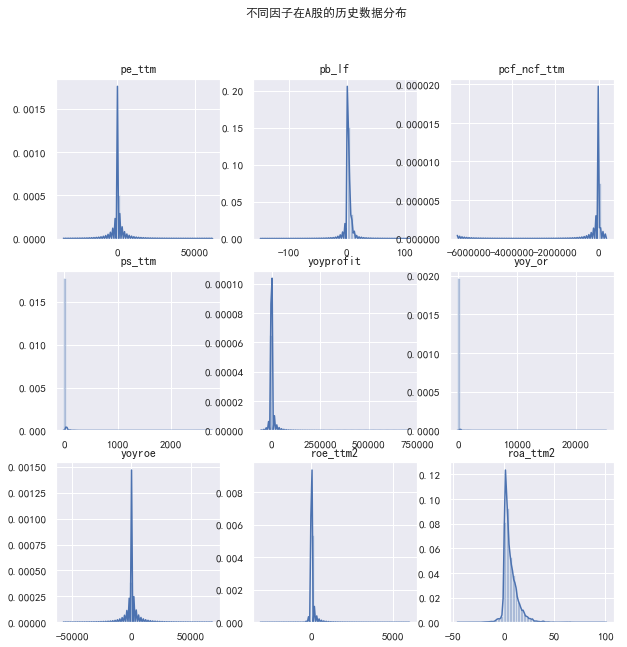

In [14]:
overview(
    source_data_function=get_data,  
    title="不同因子在A股的历史数据分布"
)


 从图中可以看出原始的因子数据都存在极差过大、分布非常不均匀的现象。
 大多数数据集中于一个值附近，但是总体来看值域又非常广。

 过大或过小的数据都会影响到统计分析的结果，所以需要对数据进行处理。

 ## 2.1 填补缺失值

 由于万德输出的当季度财务数据只在报告期有数据，而在该季度的其他月份没有数据，所以针对这个现象采用“**向前填充**”来填补缺失值。

 ```Python3
 data.fillna(method = 'ffill', inplace = True)
 ```
 针对剩余的缺失数据，我们将在数据[标准化](##2.3标准化)处理后统一填充为零。

 ## 2.2 去极值

 去极值的方法采用调整因子值中的离群值至指定阈值的上下限，从而减小**离群值**和**极值**对统计的偏差。

 离群值的阈值上下限定义的方法主要有三种：

 1. MAD法
 2. 3σ法
 3. 百分位法

 ### 2.2.1 MAD法 (Median Absolute Deviation)

 取因子的中位数，加减每个因子与该中位数的绝对偏差值的中位数乘上给定参数（此处经过调参设定默认为100倍）得到上下阈值。

 经过MAD法去极值后的因子数据概览如下：

In [17]:


def MAD_filter(factor_name, n=60):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
        n: how many times new median. (int)
    Return:
        filtered data. (pd.DataFrame)
    '''
    data = get_data(factor_name)
    values = get_values(data)
    median = np.percentile(
        values,
        50
    )
    new_median = np.percentile(
        get_values(abs(data - median)), 50
    )
    min_range = median - n * new_median
    max_range = median + n * new_median
    return data.clip(min_range, max_range, axis=1)


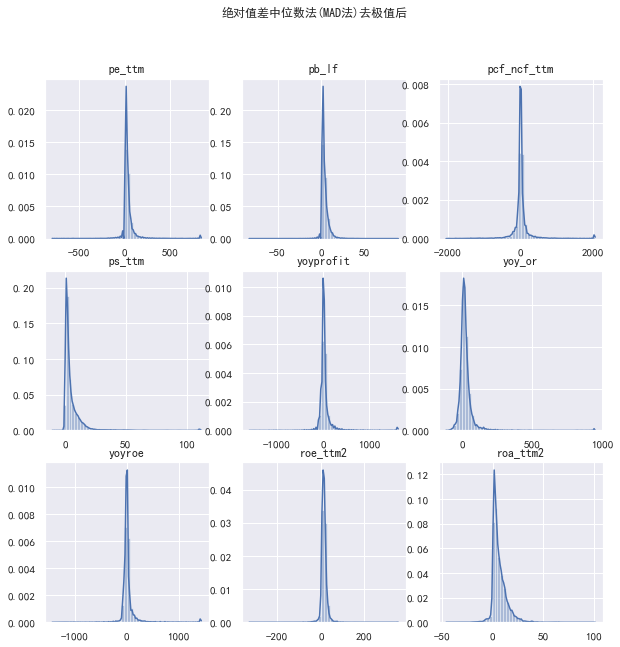

In [18]:
overview(
    source_data_function=MAD_filter,
    title="绝对值差中位数法(MAD法)去极值后"
)


 ### 2.2.2 3σ法

 取所有因子数据的标准差（即σ），偏离平均值给定参数（此处默认为三倍）标准差处设为上下阈值。

 经过3σ法去极值后的因子数据概览如下：

In [19]:


def three_sigma_filter(factor_name, n=3):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
        n: how many sigmas. (int)
    Return:
        filtered data. (pd.DataFrame)
    '''
    data = get_data(factor_name)
    values = get_values(data)
    min_range = np.mean(values) - n * np.std(values)
    max_range = np.mean(values) + n * np.std(values)
    return data.clip(min_range, max_range, axis=1)


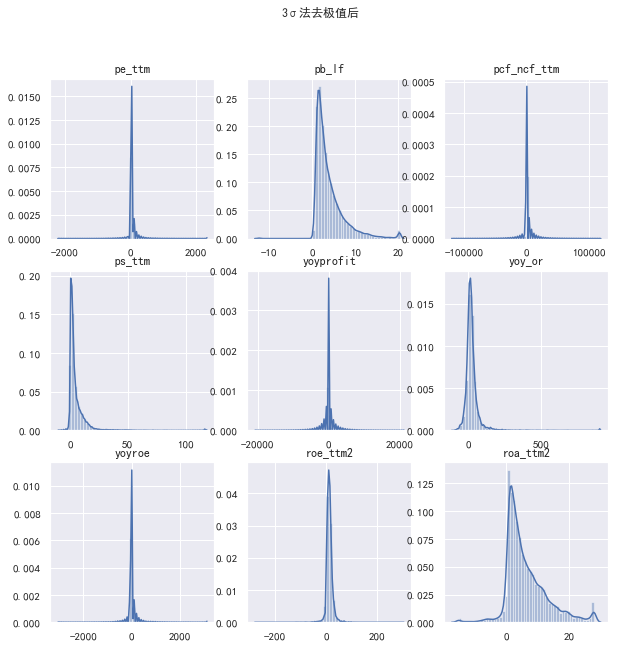

In [20]:
overview(
    source_data_function=three_sigma_filter, 
    title="3σ法去极值后"
)


 ### 2.2.3 百分位法

 取给定百分位作为上下阈值。（此处经过调参设定为下限1.5%，上限98.5%分位点）

 经过百分位法去极值后的因子数据概览如下：

In [21]:


def percentile_filter(factor_name, min=1.5, max=98.5):
    '''
    Parameters:
        factor_name: name of factors in Wind. (str)
        min: minimum percentage. (float)
        max: maximum percentage. (float)
    Return:
        filtered data. (pd.DataFrame)
    '''
    data = get_data(factor_name)
    values = get_values(data)
    min_range = np.percentile(values, min)
    max_range = np.percentile(values, max)
    return np.clip(data, min_range, max_range)



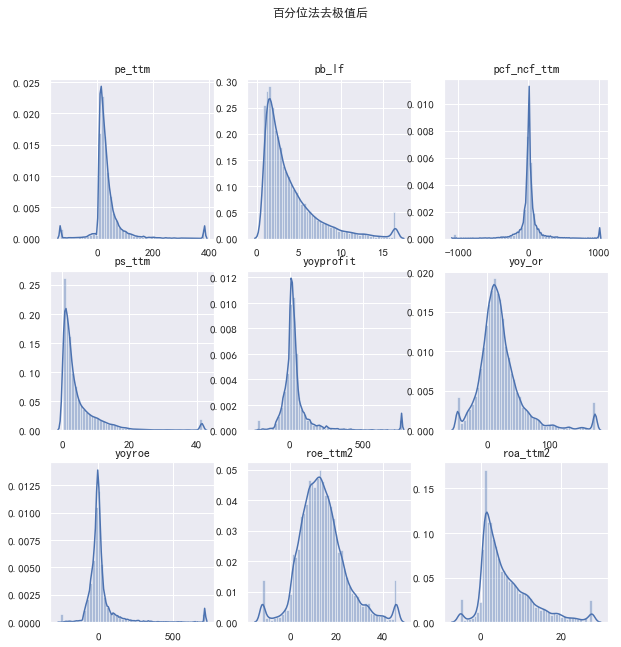

In [22]:
overview(
    source_data_function=percentile_filter, 
    title="百分位法去极值后"
)


 ### 2.2.4 去极值研究。

 实际上，即使经过调参尽可能地使三种主流的去极值方法的结果互相接近，并不至于出现过于集中的阈值，仍然有可能出现非常显著不同的效果。

 以每股现金流为例，将原始数据和三种去极值的方法处理后的因子数据放在同一张图里，由于值域相差太大，甚至根本无法从图中找到不同的方法对应的图表。（如下图：分别采用三种去极值方法处理后的每股现金流数据与其原始数据图👇）

In [23]:


def huge_deviation_filter_method_comparison(factor_name):
    '''
    Return:
        save a histogram distribution plot of 
        a hugely deviated data for different filter method comparison.
    '''
    plt.figure(figsize=(8, 5))
    sns.distplot(get_values(
        data=get_data(factor_name)
    ), label="Original")
    sns.distplot(get_values(
        data=MAD_filter(factor_name)
    ), label="MAD")
    sns.distplot(get_values(
        data=three_sigma_filter(factor_name)
    ), label="3σ")
    sns.distplot(get_values(
        data=percentile_filter(factor_name)
    ), label="Percentile")
    plt.legend()
    plt.title("不同去极值方法的比较（以营业收入同比增长率为例）")
    plt.savefig(path + "\\H3 Plots\\Comparison" + factor_name + ".png")



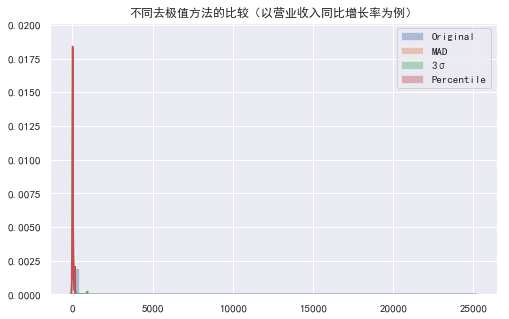

In [24]:
huge_deviation_filter_method_comparison("yoy_or")


 究其原因，是其原始数据的集中度就非常高，以至于不同方法去极值计算出相差甚远的阈值。（如下图：全部A股样本期内每股现金流的密度分布图👇）

In [25]:


def huge_deviation_original_data():
    '''
    Return:
        save a histogram distribution plot of 
        original data with huge deviation.
    '''
    plt.figure(figsize=(8, 5))
    sns.distplot(get_values(
        data=get_data("yoy_or")
    ), label="Percentile")
    plt.legend()
    plt.title("营业收入同比增长率：原始数据")
    plt.savefig(path + "\\H3 Plots\\original yoy_or.png")



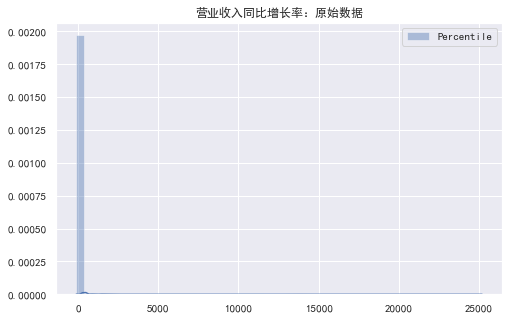

In [26]:
huge_deviation_original_data()


 所以经过百分位去极值后，尽管值域缩小了近100倍，但仍然非常集中。

 另外，这种离差过大的数据去极值的时候还会出现一个问题：造成阈值部分出现异常高的“虚假”数据，而这也是我们不愿意看到的。（如下图：每股现金流经过约束最严格的百分位去极值处理后的分布图👇）

In [27]:


def huge_deviation_filtered_data():
    '''
    Return:
        save a histogram distribution plot of 
        percentile-filtered data with huge deviation.
    '''
    plt.figure(figsize=(8, 5))
    sns.distplot(get_values(
        data=percentile_filter("yoy_or")
    ), label="Percentile")
    plt.legend()
    plt.title("营业收入同比增长率：百分位去极值")
    plt.savefig(path + "\\H3 Plots\\percentile filter yoy_or.png")



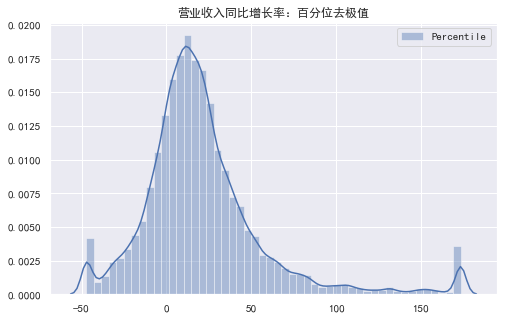

In [28]:
huge_deviation_filtered_data()


 > 注意图中 [-50, 150] 处异常的“突起”。
 >
 > 这是由于过多超出上下阈值的数据被迫调整为上下阈值，导致阈值处的数据分布特别密集。

 但在大多数情况下（数据分布相对均匀时，此处以ROE为例），各种方法以及原始数据相差不大。（如下图：资产周转率数据的原始数据及分别经过三种去极值方法处理后的分布图👇）

In [29]:


def filter_method_comparison():
    '''
    Return:
        save a histogram distribution plot of
        a normal data for different filter method comparison.
    '''
    plt.figure(figsize=(8, 5))
    sns.distplot(get_values(
        data=get_data("roa_ttm2")
    ), label="Original")
    sns.distplot(get_values(
        data=MAD_filter("roa_ttm2")
    ), label="MAD")
    sns.distplot(get_values(
        data=three_sigma_filter("roa_ttm2")
    ), label="3σ")
    sns.distplot(get_values(
        data=percentile_filter("roa_ttm2")
    ), label="Percentile")
    plt.legend()
    plt.title("不同去极值方法的比较（以总资产净利率为例）")
    plt.savefig(path + "\\H3 Plots\\Comparison(roa_ttm2).png")



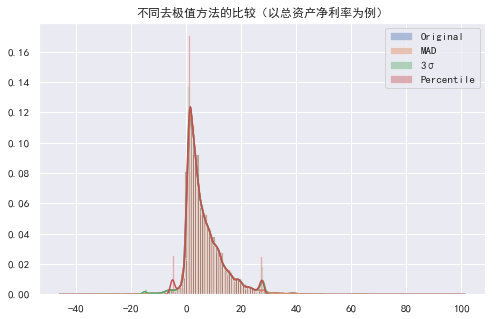

In [30]:
filter_method_comparison()


 经过比较研究，我们最终选取阈值选取相对最为合理，较少阈值异常“突起”，同时保留较宽值域的**参数值为60的MAD法**进行去极值处理。

 ## 2.3 标准化

 标准化处理数据的目的就是去除其**量纲**。

 这样做可以使得：

 - 数据更加集中
 - 不同数据之间可以互相比较和进行回归等

 主流的标准化的方法有两种：

 标准化方法|原理|优点|缺点
 :--|:--|:--:|:--:
 对原始因子值标准化|减去均值后，除以标准差|保留更多信息|对数据分布有要求
 对因子排序值标准化|因子排序值进行上述处理|适用性更广泛|非参数统计法

 它们都能使得数据的：

 - 均值为0
 - 标准差为1

 由于已经对数据进行去极值处理，我们最终选取对原始因子值进行标准化(z-score)的方法进行标准化。

 > 2.1， 2.2， 2.3的数据处理部分的：
 >
 > 数据保存在"H3 Data/Processed Data"文件夹里。

In [0]:
# Use z-score method to standardize.


def standardize(factor_name):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
        start_year:the start_year the data start
    Return:
        standardized and Filtered (MAD) data. (pd.DataFrame)
    '''
    data = MAD_filter(factor_name)
    # data = data.fillna(0)
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std


In [0]:


def process_and_store_data():
    '''
    Return:
        save processed data in "\\H3 Data\\Processed Data\\".
        ("processed" means filtered & standardized.)
    '''
    for factor in get_factors_list():
        processed_data = standardize(factor)
        file_path = path + "\\H3 Data\\Processed Data\\" + factor + ".csv"
        processed_data.to_csv(file_path)


In [0]:
# process_and_store_data()



 （如下图为经过去极值、标准化处理后的数据密度分布图一览👇）

In [7]:


def overview_processed_data():
    # Get an overview of processed data.
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(int("33" + str(i+1)))
        sns.distplot(get_values(
            data=get_data(get_factors_list()[i], category="Processed")
        ))
        plt.title(get_factors_list()[i])
    plt.suptitle("经过处理后的A股因子数据密度分布图一览")
    plt.savefig(path + "\\H3 Plots\\Processed Data.png")



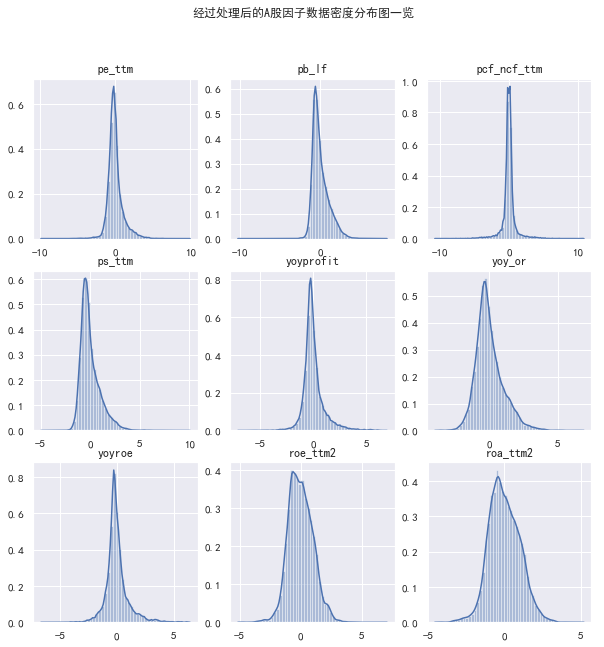

In [8]:
overview_processed_data()


 ## 2.4 中性化

 中性化的目的是剔除数据中多余的风险暴露。

 根据某些因子（指标）选股的时候，由于某些因子之间具有较强的相关性，故时常会有我们不希望看到的“**偏向**”，导致投资组合不够**分散**。

 例如以下四个指标：

 - 市现率
 - 净利润同比增长率
 - 净资产收益率同比增长率
 - 存货周转率

In [9]:


def get_industry_list():
    '''
    Return:
        industry list in HS300 stocks list.
    '''
    return list(get_data("industry_sw").iloc[:, 0].unique())


In [10]:


def industry_comparison(factor_name):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        average factor value of each industries. (pd.DataFrame)
            index: industry. (str)
            columns: factor name. (str)
    '''
    # All industry in HS300.
    # Use certain factor data for comparison example between industry.
    compare_data = get_data(factor_name, start_year='2009')
    compare_industry = pd.DataFrame(
        index=get_industry_list(),
        columns=[factor_name]
    )
    for industry in get_industry_list():
        industry_stock_code_list = list(get_data("industry_sw")[
            get_data("industry_sw").iloc[:, 0] == industry  
        ].index)
        # Some industry is not in HS300.
        try:
            industry_data = compare_data[industry_stock_code_list]
            compare_industry.loc[
                industry, factor_name
            ] = np.mean(np.mean(industry_data))
        except:
            continue
    compare_industry.dropna(inplace=True)
    return compare_industry


 沪深300股票指数中共包含17个行业（根据申万一级行业分类），分别统计沪深300指数中各行业以上四个指标的平均值，结果如下图所示👇。

In [11]:


def plot_industry_comparison():
    '''
    Return:
        save a 2*2 plot of average factor of each industries, 
        which are all siginificantly different. 
    '''
    # Choose 4 factors that's significantly different among industries.
    significant_comparison_industry_list = [
        "pcf_ncf_ttm",
        "yoyprofit",
        "yoyroe",
        "invturn"
    ]
    plt.figure(figsize=(21, 18))  # it's a big plot.
    for i in range(len(significant_comparison_industry_list)):
        plot_data = industry_comparison(
            significant_comparison_industry_list[i]
        )
        plt.subplot(int("22" + str(i+1)))
        sns.barplot(
            x=plot_data.index,
            y=significant_comparison_industry_list[i],
            data=plot_data
        )
        plt.xticks(rotation=60)  # rotate to avoid overlap text.
        plt.title(
            significant_comparison_industry_list[i],
            fontsize=21
        )
    plt.suptitle(
        "沪深300中不同行业部分因子平均值比较",
        fontsize=36
    )
    plt.savefig(path + "\\H3 Plots\\Industry Comparison.png")



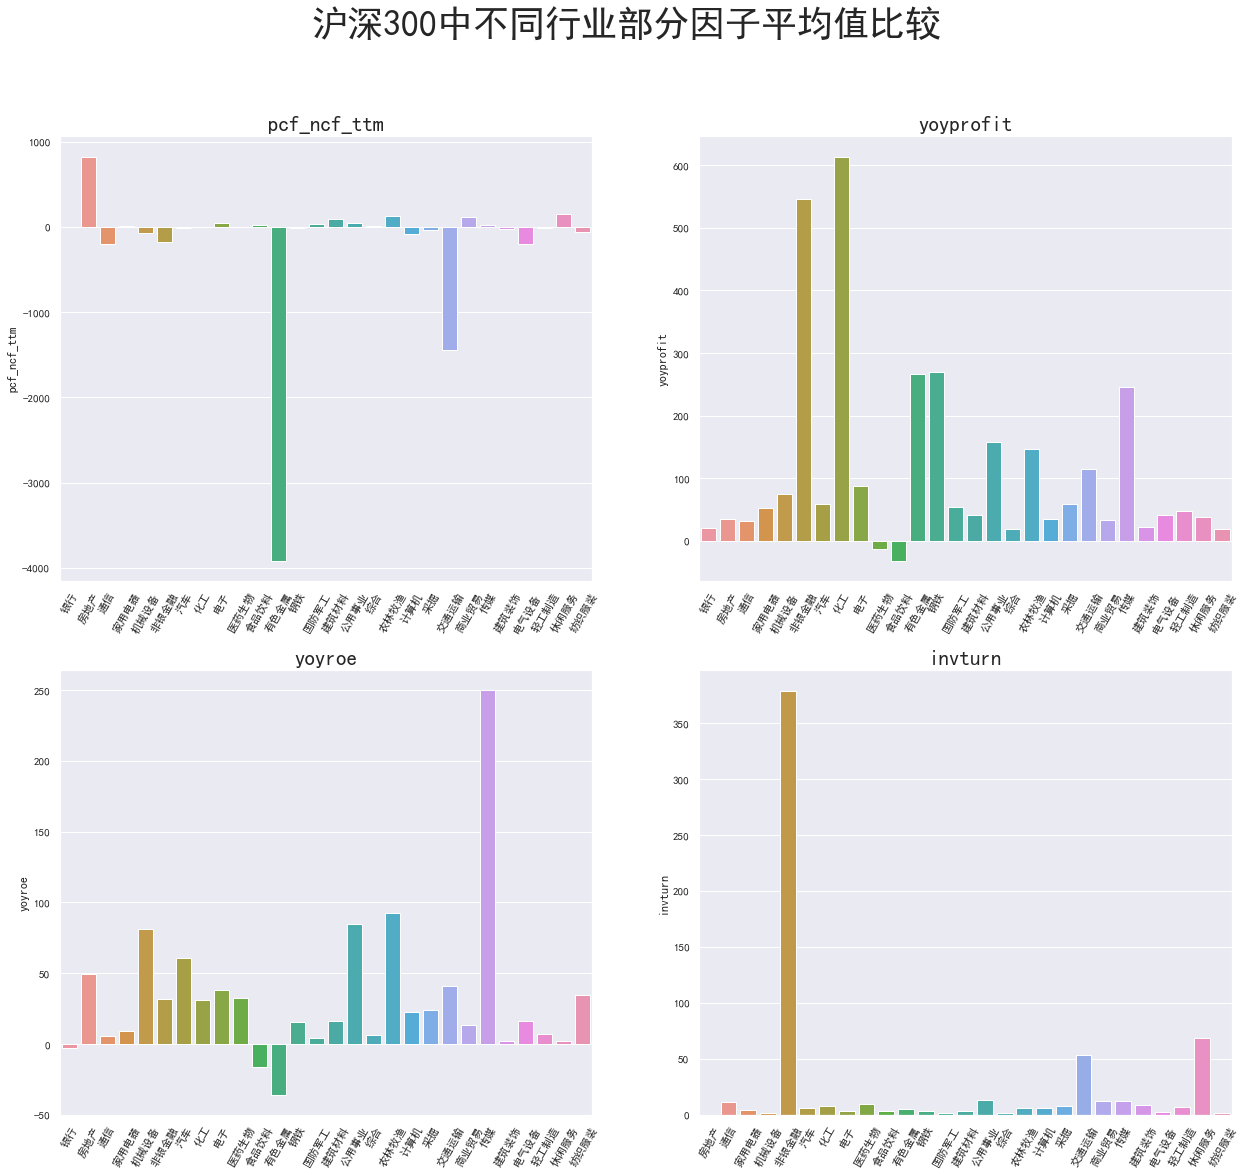

In [12]:
plot_industry_comparison()


 从图中可以看到，不同行业的不同指标相差十倍、千倍乃至万倍都有。

 > *有色金属行业的平均市现率是银行业的近负四十万倍。*

In [0]:
print(round(
    industry_comparison("pcf_ncf_ttm").loc["有色金属", "pcf_ncf_ttm"] /
    industry_comparison("pcf_ncf_ttm").loc["家用电器", "pcf_ncf_ttm"],
    0
))


 那么，依据市现率因子选取出的股票必然对平均市现率高的行业有偏向，而我们希望投资组合中的行业尽可能分散，故我们希望对行业进行中性化。（同理，我们也希望对市值进行中性化。）

 中性化的主要做法就是通过回归得到一个与风险因子（行业因子、市值因子）**线性无关**的因子。（即线性回归后的残差项作为中性化后的新因子。）如此一来，中性化处理后的因子与风险因子之间的相关性就严格为零。

 > 不过这样做中性化并不一定总能彻底地剔除因子的多余信息。因为线性回归要求两个前提假设：
 >
 > - 因子之间线性相关
 > - 残差正态独立同分布
 >
 > 而在因子数据中这两个假设都不一定成立。（例如在[2.2去极值](##2.2去极值)步骤中密度过高的阈值就对数据的分布造成了破坏）

 但直观的说，根据[Brinson资产配置分析](https://www.investopedia.com/terms/a/attribution-analysis.asp)超额收益理论来看，如果投资组合中风险因子配置资产权重等于基准资产中其之权重，则做到了中性化。

 此处简便起见，我们依然采用线性回归作为中性化的处理方法。

 回归方式如下：

 - 被解释变量：前述数据处理后的因子数据

 - 解释变量：

   - 市值因子
   - 行业因子（作为指示变量）

 最终回归方程的**残差**项即为中性化后的因子暴露。

 （如下图，为选取四个因子指标进行行业中性化前后的结果，以展示中性化的一般结果👇，可以看出中性化导致分布更均匀、更接近均值）

In [13]:


def get_industry_exposure(factor_name):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        industry exposure data. (pd.DataFrame)
    '''
    file_path = path + "\\H3 Data\\Neutralized Data\\industry exposure " + factor_name + ".csv"
    if os.path.isfile(file_path):
        industry_exposure = pd.read_csv(
            open(
                file_path,
                'r',
                encoding="utf-8"
            ),
            index_col=[0]
        )
    else:
        # Don't know why but different factor data \
        # has different hs300 stocks list,
        # so specify which factor is essential.
        hs300_stock_list = list(get_data(
            factor_name, 
            category="Processed", 
            start_year='2009'
        ).columns)
        industry_exposure = pd.DataFrame(
            index=get_industry_list(),
            columns=hs300_stock_list
        )
        for stock in hs300_stock_list:
            try:
                industry_exposure.loc[
                    get_data("industry_sw").loc[
                        stock,
                        "INDUSTRY_SW"
                    ],
                    stock
                ] = 1
            except:
                continue
        industry_exposure.fillna(0, inplace=True)
        industry_exposure.to_csv(file_path)
    return industry_exposure


In [14]:


def neutralize(
    factor_name, 
    start_year="2009", 
    market_capital=True,
    industry=True
):
    '''
    Parameters:
        factor_name: name of factors in Wind. (str)
        market_capital: whether market-capital-neutralize or not. (bool)
        industry: whether industry-neutralize or not. (bool)
    Return:
        neutralized data. (pd.DataFrame)
    '''
    # don't know why but there's still nan.
    y = get_data(
        factor_name, 
        category="Processed", 
        start_year="2009"
    ).T.fillna(0)
    industry_dummy = get_industry_exposure(factor_name)
    if market_capital:
        ln_market_capital = get_data(
            "val_lnmv", 
            category="Processed", 
            start_year='2009'
        )
        if industry:
            x = pd.concat(
                [
                    ln_market_capital,
                    industry_dummy
                ],
                axis=1
            ).T
        else:
            x = ln_market_capital.T
    elif industry:
        x = industry_dummy.T
    
    x.fillna(0, inplace=True)
    y = y.loc[x.index, :]
    
    result = sm.OLS(
        y.astype(float),
        x.astype(float)
    ).fit()
    
    return result.resid.T


In [15]:


def plot_industry_neutralization(factor_name):
    '''
    Return: 
        a plot of neutralization comparison.
    '''
    plt.figure(figsize=(8, 5))
    sns.kdeplot(get_values(
        data=get_data(factor_name, category="Processed")
    ), label="未经中性化")
    sns.kdeplot(get_values(
        data=neutralize(
            factor_name,
            market_capital=False,
            industry=True
        )
    ), label="行业中性化")
    plt.legend()
    plt.title("对" + factor_name + "进行中性化处理前后比较")
    plt.savefig(path + "\\H3 Plots\\industry neutralization.png")


In [16]:


def overview_industry_neutralization(factor_list):
    '''
    Parameter:
        factor_list: list of factor names. (list)
    Return:
        save a 2*2 plot of neutralization comparison.
    '''
    plt.figure(figsize=(10, 10))
    for i in range(len(factor_list)):
        plt.subplot(int("22" + str(i+1)))
        sns.kdeplot(get_values(
            data=get_data(factor_list[i], category="Processed")
        ), label="未经中性化")
        sns.kdeplot(get_values(
            data=neutralize(
                factor_list[i],
                market_capital=False,
                industry=True
            )
        ), label="行业中性化")
        plt.legend()
        plt.title("对" + factor_list[i] + "进行行业中性化处理前后比较")
    plt.suptitle("行业中性化的典型结果")
    plt.savefig(path + "\\H3 Plots\\overview industry neutralization.png")


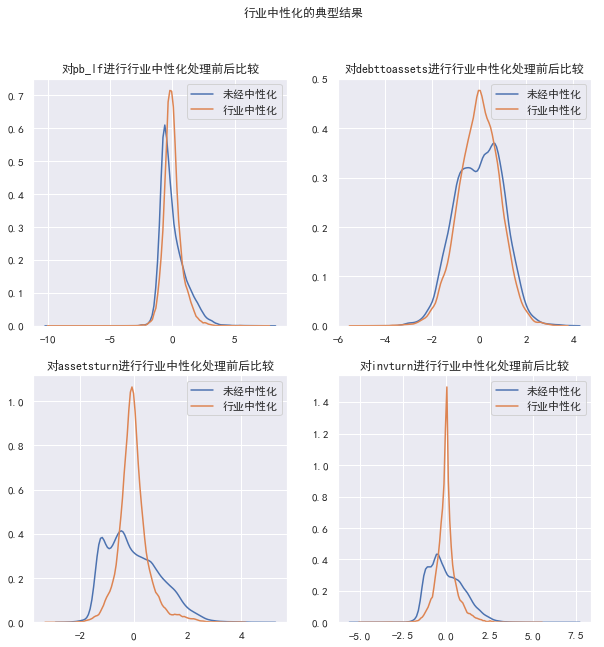

In [17]:
overview_industry_neutralization([
    "pb_lf",
    "debttoassets",
    "assetsturn",
    "invturn"
])


 对市值进行中性化也有类似的效果。（如下图为对"pb_lf"因子进行市值中性化的结果👇）

In [18]:


def plot_market_neutralization(factor_name):
    '''
    Return: 
        a plot of neutralization comparison.
    '''
    plt.figure(figsize=(8, 5))
    sns.kdeplot(get_values(
        data=get_data(factor_name, category="Processed")
    ), label="未经中性化")
    sns.kdeplot(get_values(
        data=neutralize(
            factor_name,
            market_capital=True,
            industry=False
        )
    ), label="市值中性化")
    plt.legend()
    plt.title("对" + factor_name + "进行市值中性化处理前后比较")
    plt.savefig(path + "\\H3 Plots\\market neutralization.png")


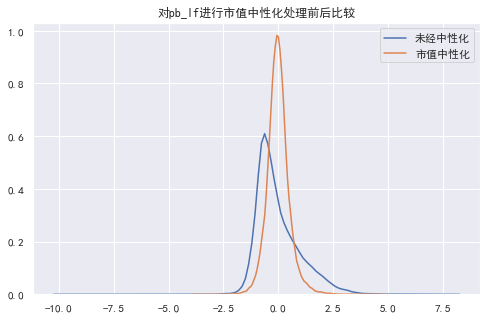

In [19]:
plot_market_neutralization("pb_lf")


 同样是"pb_lf"因子，同时对市值和行业进行中性化👇，效果也是相近的。

In [20]:


def plot_neutralization(factor_name):
    '''
    Return: 
        a plot of neutralization comparison.
    '''
    plt.figure(figsize=(8, 5))
    sns.kdeplot(get_values(
        data=get_data(factor_name, category="Processed")
    ), label="未经中性化")
    sns.kdeplot(get_values(
        data=neutralize(
            factor_name,
            market_capital=True,
            industry=True
        )
    ), label="行业市值中性化")
    plt.legend()
    plt.title("对" + factor_name + "进行行业市值中性化处理前后比较")
    plt.savefig(path + "\\H3 Plots\\industry & market neutralization.png")


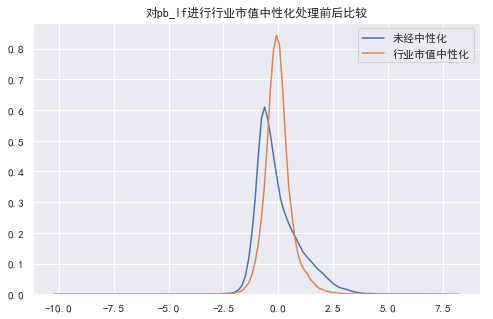

In [21]:
plot_neutralization("pb_lf")



 > 数据处理中性化部分的：
 >
 > 数据保存在"H3 Data/Neutralized Data"文件夹里。

 最终经过所有因子数据处理步骤之后，原来的因子数据分布图变为了这样。

 （经过所有数据处理步骤后的因子数据密度分布图一览👇）

In [22]:


def neutralize_and_store_data():
    '''
    Return:
        save industry neutralized data in 
        "\\H3 Data\\Neutralized Data\\".
    '''
    for factor in get_factors_list():
        file_path = path + "\\H3 Data\\Neutralized Data\\" + factor + ".csv"
        neutralized_data = neutralize(
            factor,
            market_capital=True,
            industry=True
        )
        neutralized_data.to_csv(file_path)



In [23]:
# neutralize_and_store_data()


In [24]:


def overview_after_data_processing():
    # Get an overview of data after processing.
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(int("33" + str(i+1)))
        factor_name = get_factors_list()[i]
        sns.distplot(get_values(
            data=get_data(factor_name, category="Neutralized")
        ))
        plt.title(factor_name)
    plt.suptitle("经过数据处理后的不同因子在A股的历史数据分布")
    plt.savefig(path + "\\H3 Plots\\overview after data processing.png")



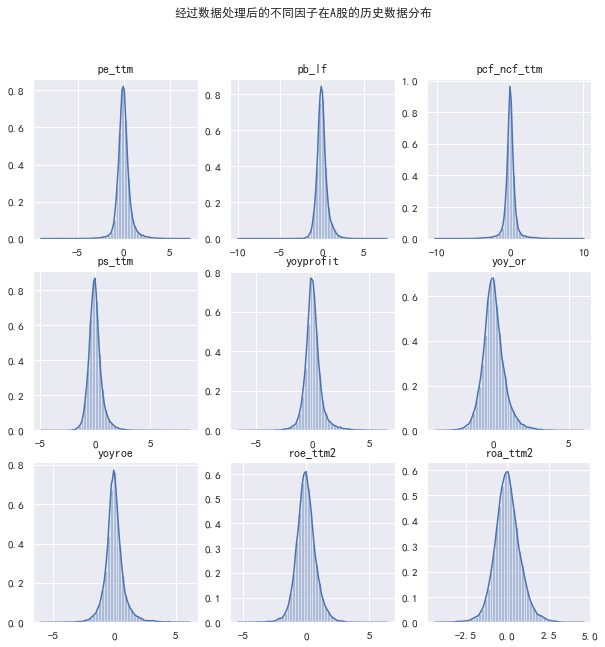

In [25]:
overview_after_data_processing()


# Step 3：大类因子合成

 前面两个步骤已经把风格因子的细分类因子数据经过数据处理并保存了下来，
 这一步把细分类因子合成为大类因子。使得最终合成后只剩下：

 - VALUE
 - GROWTH
 - PROFIT
 - QUALITY
 - VOLATILITY
 - MOMENTUM
 - LIQUIDITY

 这七个因子，我们的目标就是构建这七个因子的**纯因子组合**。

 > 从这一步开始为方便提取数据，将数据从"pandas.DataFrame"
 转换为"pandas.PanelData"。
 >
 > 数据格式为：
 >
 > - index: stock codes
 > - factor names
 >
 > 可以用以下方法提取特定时间的所有因子的所有股票数据：
 >
 > ```Python3
 > Large_factor.major_xs("20050131")
 > ```

 大类因子合成的方式是通过IC_IR加权合成。

 > 大类因子合成部分的：
 >
 > 数据保存在"H3 Data/Composition Data"文件夹里。

In [0]:
# Turn dataframe into panel data.


def get_group_data(factor_list, start_year="2009"):
    datadict = {}
    for i in factor_list:
        # This should be the processed data.
        df = get_data(
            i, 
            category="Neutralized", 
            start_year=start_year
        )  
        datadict[i] = df
    panel = pd.Panel(datadict)
    return panel


In [0]:


class Large_factor_merge(object):
    def __init__(self, Large_factor):
        if Large_factor == 'VALUE':
            list = ["pe_ttm", "pb_lf", "pcf_ncf_ttm", "ps_ttm"]

        elif Large_factor == 'GROWTH':
            list = ["yoyprofit", "yoy_or", "yoyroe"]

        elif Large_factor == 'PROFIT':
            list = ["roe_ttm2", "roa_ttm2"]

        elif Large_factor == 'QUALITY':
            list = ["debttoassets", "assetsturn", "invturn"]

        elif Large_factor == 'MOMENTUM':
            list = ['pct_chg_1m', 'pct_chg_3m', 'pct_chg_6m']

        elif Large_factor == 'VOLATILITY':
            list = ["stdevry_3m", "stdevry_6m"]

        elif Large_factor == 'LIQUIDITY':
            list = ["tech_turnoverrate60", "tech_turnoverrate20"]

        self.data = get_group_data(list, "2007")
        self.data_2009 = get_group_data(list, "2009")
        self.Large_factor = Large_factor
    # Define the following function for you can read clearly 
    # and can acquire the data of every step.

    def Caculate_IC(self):
        stock_return = get_data(
            "pct_chg_1m", 
            category="Neutralized", 
            start_year="2007"
        )  # This will be modified
        datadict = {}
        for i in self.data.items:
            df = self.data[i]
            IC = pd.DataFrame(columns=['IC_monthly'],
                              index=df.index[0:len(df)-1])
            IC_group = []
            for j in range(len(df)-1):
                cor = df.iloc[j].corr(stock_return.iloc[j+1])
                IC_group.append(cor)
            IC['IC_monthly'] = IC_group
            datadict[i] = IC
        IC_Large = pd.Panel(datadict)
        return IC_Large

    def Factors_merge_Static(self):
        IC_Large = self.Caculate_IC()
        weight_df = pd.DataFrame(
            columns=['weights'], 
            index=self.data.items
        )
        weight = []
        for i in IC_Large.items:
            df = IC_Large[i]
            IR = df.iloc[-24:, 0].mean()/df.iloc[-24:, 0].std()
            weight.append(IR)
        #weight = [x / sum(weight) for x in weight]  # adjust the sum of weight to 1.0
        weight_df['weights'] = weight
        weight = weight_df
        Factors_sum = pd.DataFrame(
            0, 
            columns=self.data_2009.minor_axis, 
            index=self.data_2009.major_axis
        )
        for i in self.data.items:
            df = self.data_2009[i]
            new_df = df * weight.loc[i, 'weights']
            Factors_sum = Factors_sum + new_df
        return Factors_sum

    def Factors_merge_dynamic(self):
        IC_Large = self.Caculate_IC()
        weight_df = pd.DataFrame(columns=IC_Large.major_axis[24:], index=IC_Large.items)
        for i in IC_Large.items:
            for j in range(24, len(IC_Large.major_axis)):
                df = IC_Large[i]
                IR = df.iloc[j - 23:j+1, 0].mean() / df.iloc[j - 23:j+1, 0].std()
                weight_df.loc[i, IC_Large.major_axis[j]] = IR
        #weight_df = weight_df.apply(lambda x: x / sum(x))
        weight = weight_df
        Factors_sum = pd.DataFrame(0, columns=self.data.minor_axis, index=weight.columns)
        for i in self.data_2009.items:
            df = self.data_2009[i]
            new_df = df.mul(weight.loc[i], axis=0)
            Factors_sum = Factors_sum + new_df
        return Factors_sum


In [0]:


def Merge_and_store_factors_Dynamic():
    Factor_dict = {}
    for i in ['VALUE','GROWTH','PROFIT','QUALITY','MOMENTUM','VOLATILITY','LIQUIDITY']:
        Factor_data = Large_factor_merge(i).Factors_merge_dynamic()
        Factor_dict[i] = Factor_data
        file_path = path + "\\H3 Data\\Large Factor Dynamic Data\\" + i + ".csv"
        Factor_data.to_csv(file_path)
    Large_factor = pd.Panel(Factor_dict)
    return Large_factor
Large_factor_dynamic = Merge_and_store_factors_Dynamic()
# when you want to use one factor,you can edit'Large_factor[the name of the factor]'

In [0]:


def Merge_and_store_factors_Static():
    Factor_dict = {}
    for i in ['VALUE','GROWTH','PROFIT','QUALITY','MOMENTUM','VOLATILITY','LIQUIDITY']:
        Factor_data = Large_factor_merge(i).Factors_merge_Static()
        Factor_dict[i] = Factor_data
        file_path = path + "\\H3 Data\\Large Factor Static Data\\" + i + ".csv"
        Factor_data.to_csv(file_path)
    Large_factor = pd.Panel(Factor_dict)
    return Large_factor
Large_factor_Static = Merge_and_store_factors_Static()


In [29]:

def get_Large_Factors(factor_name, type):
    category = "Large Factor " + type
    data = get_data(factor_name, category=category)
    return data


In [30]:


def overview_Large_factors(type):
    # Get an overview of data after processing.
    plt.figure(figsize = (10, 10))
    for i in range(7):
        plt.subplot(int("33" + str(i+1)))
        factor_name = get_large_factors_list()[i]
        sns.distplot(get_values(
            data = get_Large_Factors(factor_name,type)
        ))
        plt.title(factor_name)
    plt.suptitle("大类因子在A股的历史数据分布(" + type + ' synthesis)')
    plt.savefig(path + "\\H3 Plots\\Large Factors "+ type +".png")


 合成后的大类因子数据如下图，动态权重合成👇。

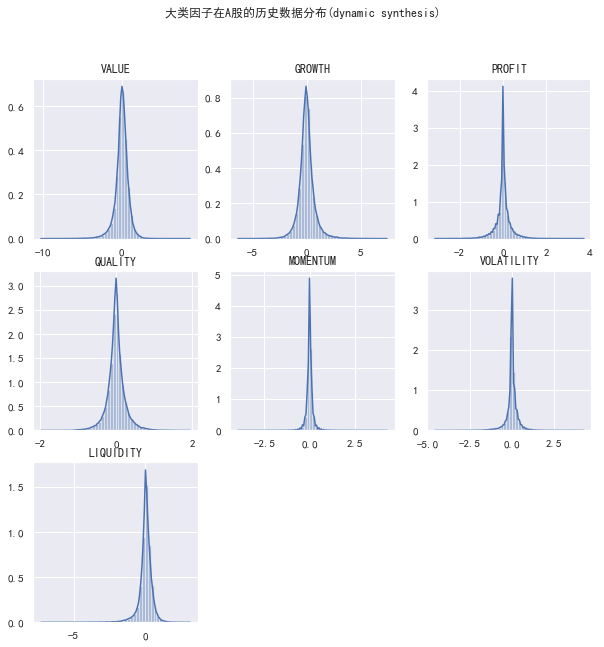

In [31]:
overview_Large_factors('dynamic')


 静态权重合成👇。

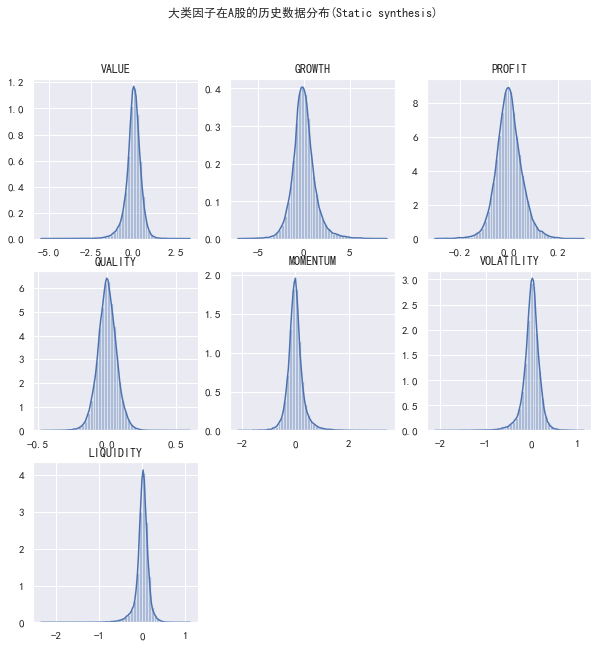

In [32]:
overview_Large_factors('Static')


# Step 4：收益预测模型

通过股票收益率数据，对合成好的大类因子数据（因子暴露）进行回归，利用回归系数（因子收益），采取一定方式来预测下一期的因子收益，从而进行股票收益率预测。

由于核心在于因子收益的预测，此处简便起见直接采用过去一年月度因子收益的均值，作为下一期因子收益的预测值，最后来构建股票收益预测模型。

## 4.1 多元线性回归

进行如下形式的多元线性回归：

$r_j^t = \sum_{s=1}^S X_{js}^t*f_s^t+ \sum_{k=1}^K X_{jk}^t*f_k^t+X_{jm}^t*f_m^t+u_j^t$

| 字符意义   | 股票j在t期在行业s上的暴露    |
| ---------- | ---------------------------- |
| $r_j^t$    | 股票j在t期的收益率           |
| $f_s^t$    | 行业s在t期的收益率           |
| $X_{js}^t$ | 股票j在t期在行业s上的暴露    |
| $f_k^t$    | 因子k在t期的收益率           |
| $X_{jk}^t$ | 股票j在t期在因子k上的暴露    |
| $f_m^t$    | 市场因子在t期的收益率        |
| $X_{jm}^t$ | 股票j在t期在市场因子上的暴露 |
| $u_j^t$    | 股票j的残差收益率            |

为解决异方差性，使用了WLS加权最小二乘法进行回归。

从每次回归的$R^2$来看，模型的解释性较好。

## 4.2 估计因子预期收益 

由多元线性回归可以得到所有因子的历史收益率序列，使用历史数据估计T+1期因子预期收益率的方法有很多种。

此处采取历史均值法，N=12。（即采取前12个月的因子历史收益率均值作为T+1期因子的预期收益率）

$f_k^{T+1}=\dfrac{\sum_{t=T-N+1}T f_k^t}{N}$

## 4.3 计算股票预期收益

根据因子预期收益估计值$(f_1^{T+1},f_2^{T+1},f_3^{T+1}...f_K^{T+1})$与T期因子载荷矩阵$X^{T}$得到股票预期收益：

$r_j^{T+1} = \sum_{s=1}^S X_{js}^T*f_s^{T+1}+ \sum_{k=1}^K X_{jk}^T*f_k^{T+1}+X_{jm}^T*f_m^{T}+u_j^{T+1}$

即可计算出T+1期个股的预期收益率 $(r_1^{T+1},r_2^{T+1},r_3^{T+1}...r_N^{T+1})$

## 4.4 模型结果输出以及模型评估

由4.1~4.3得到的预期收益模型，我们可以计算出300个股票T+1期（2019年2月）的预期收益率—— $\hat{y} $（300*1）

同时，通过万德数据库获取300个股票T+1期的真实收益率—— $y$（300*1）

回归预测报告MSE值（均方差）与RMSE值（均方根）分别为0.067和0.259.

其中$MSE=\dfrac{SSE}{n}, RMSE=\sqrt{MSE}$

我们发现问题出在$f_k^{T+1}$ 预测，在使用历史因子收益平均值作为预测值时，正负值进行平均后估计值接近0，如图为最近一月的因子收益与最近12月因子收益平均值对比图：

因此我们采用其他方法对$f_k^{T+1}$进行预测，如ARIMA模型。

**ARIMA**：

ARIMA(p,d,q):	$\widehat{y_t} =  \mu +  \phi_1*y_{t-1} + ...+ \phi_p*y_{t-p} + \theta_1*e_{t-1} +...+\theta_q*e_{t-q}$

其中, $\phi$表示AR的系数，$\theta$表示MA的系数

本身平稳的因子有：

VALUE；PROFIT；MOMENTUM；LIQUIDITY；房地产；通信；家用电器；机械设备；非银金融；汽车；化工；电子；医药生物；有色金属；钢铁；国防军工；综合；农林牧渔；采掘；交通运输；商业贸易；建筑装饰；电气设备；轻工制造；纺织服装 

**后续工作**：

将本身不平稳的因子通过不同滞后期的差方项ADF检验进行平稳化。

根据ACF和PACF找出ARIMA(p,d,q)的参数，对每个因子进行预测。

In [0]:

def get_regression_data(start_year, type):
    # get 7+1 data list for one stock
    data = pd.DataFrame(
        columns=[
            'return', 'VALUE', 'GROWTH', 'PROFIT', 
            'QUALITY', 'MOMENTUM', 'VOLATILITY', 'LIQUIDITY'
        ]
    )
    for factor_name in [
        'VALUE', 'GROWTH', 'PROFIT', 
        'QUALITY', 'MOMENTUM', 'VOLATILITY', 'LIQUIDITY'
    ]:
        data[factor_name] = get_Large_Factors(factor_name, type).loc[start_year]
    
    data['return'] = get_data("pct_chg_1m", category="Processed").loc[start_year]

    return data


In [0]:


def regression_model(y, X):
    model = sm.WLS(y, X)  # 加权最小二乘法 解决异方差性
    results = model.fit()
    # results.summary
    return results.params


In [0]:


def run_regression(type):
    time_list = get_Large_Factors('VALUE', type).index[:-1]
    param_df = pd.DataFrame(columns=time_list)
    for start_year in time_list:
        regression_data = get_regression_data(start_year, type)
        y = regression_data['return']
        X = regression_data.iloc[:, 1:]
        param = regression_model(y, X)
        param_df[start_year] = param
    return param_df

# run_regression('Static')==>进行回归


In [0]:
# 估计因子预期收益，此处采用N=12的历史均值法


def estimated_factor_expected_income(type):
    F = run_regression(type).T
    N = 12
    time_list = get_Large_Factors('VALUE', type).index
    F_predict = pd.DataFrame(columns=F.columns)
    for i in range(N, len(time_list)):
        F_predict.loc[time_list[i]] = list(F.iloc[i-N:i].mean())
    return F_predict


 # STEP 5
 
- 优化目标：组合预期收益率最大化 
- 约束条件：对目标纯因子不做约束，对非目标纯因子偏离要求不超过 0.03，风险因子行业和市值，偏离不超过 0.03

根据上一个步骤构造的收益预测模型，以最大化预期收益率为优化目标，构建纯因子模型。

之所以要对模型进行约束，是因为即使在进行了中性化等数据处理后，仍然可能出现风险过多地暴露在某一方面的现象的情况。

我们通过动态规划的方式优化模型以在约束条件内达到目标，最终构建沪深300指数纯因子组合。